In [1]:
import cv2
import numpy as np
import nibabel as nibS
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K



2024-07-03 14:23:20.114516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 14:23:20.114785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 14:23:20.581791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 14:23:21.881355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 14:23:37.624988: W tensorflow/compiler/tf2

In [4]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss

    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [4]:
def predictByPath(case_path, case):
    VOLUME_SLICES = 155  # You need to adjust this based on your data
    IMG_SIZE = 128  # Assuming your model expects 128x128 input images
    VOLUME_START_AT = 0  # Start slice index

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path_flair = os.path.join(case_path, f'{case}_flair.nii')
    vol_path_t1ce = os.path.join(case_path, f'{case}_t1ce.nii')

    flair = nib.load(vol_path_flair).get_fdata()
    ce = nib.load(vol_path_t1ce).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)

In [20]:
def showPredictsById(case, start_slice=60):
    IMG_SIZE = 128
    SEGMENT_CLASSES = ['background', 'necrotic', 'edema', 'enhancing']
    path = f"./data/MICCAI_BraTS_2019_Data_Training/HGG"  # Adjust the path to your dataset

    gt = nib.load(os.path.join(path, f'{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, 'BraTS19_2013_3_1_flair.nii')).get_fdata()
    p = predictByPath(path, case)
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):  # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')
    
    # Adjusted line for displaying all classes prediction
    combined_prediction = np.sum(p[start_slice, :, :, 1:4], axis=-1)
    axarr[2].imshow(combined_prediction, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All classes')
    
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()


1/1 [==============================] - 0s 185ms/step


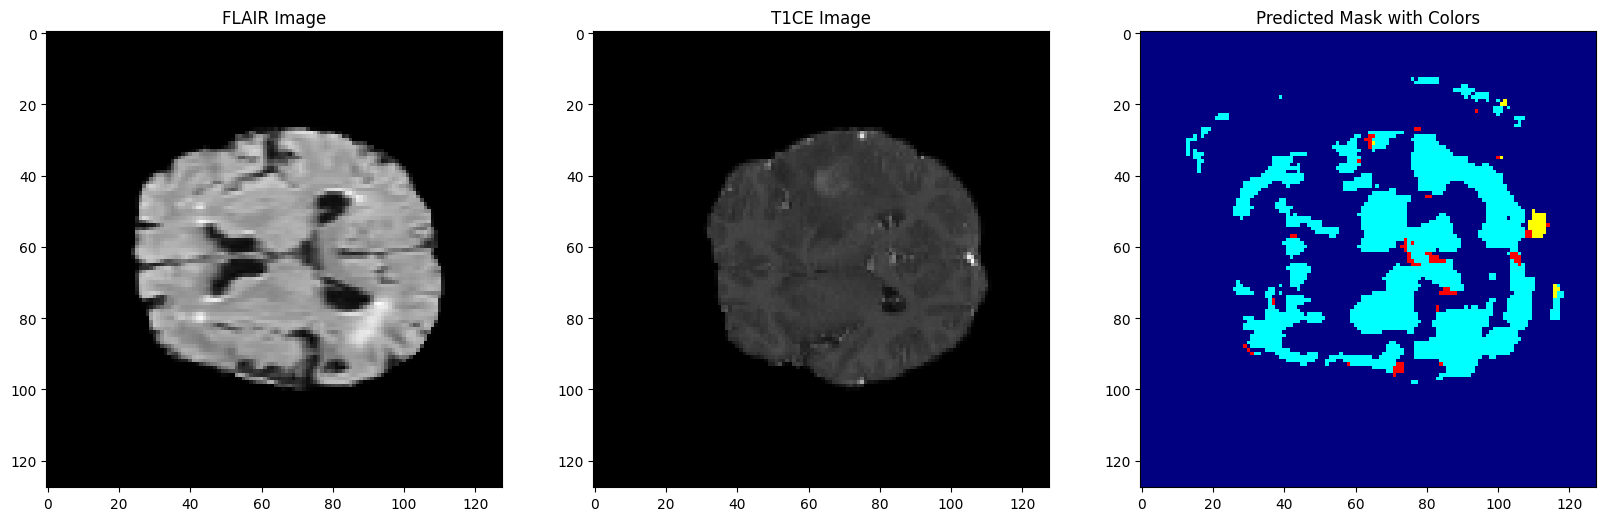

Tumor detected in the image.


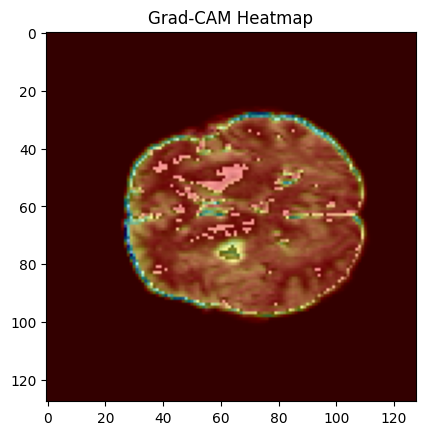

In [14]:
import tensorflow as tf
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import os

# Define the custom metrics
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_loss += loss
    total_loss /= class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, 3])) + epsilon)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Load the model with the custom metrics
model = tf.keras.models.load_model('model_2019_350.h5',
                                   custom_objects={
                                       'dice_coef': dice_coef,
                                       'dice_coef_necrotic': dice_coef_necrotic,
                                       'dice_coef_edema': dice_coef_edema,
                                       'dice_coef_enhancing': dice_coef_enhancing,
                                       'precision': precision,
                                       'sensitivity': sensitivity,
                                       'specificity': specificity,
                                       'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)
                                   }, compile=False)

# Load and preprocess the image
image_path_flair = './BraTS19_2013_13_1_flair.nii'
image_path_t1ce = './BraTS19_2013_3_1_t1ce.nii'

image_flair = nib.load(image_path_flair).get_fdata()
image_t1ce = nib.load(image_path_t1ce).get_fdata()

# Assume the model expects images of shape (128, 128, 2)
# Here we need to resize each slice to 128x128 and concatenate two slices to form a 3D input
slice_index = image_flair.shape[2] // 2  # Taking a slice from the middle
slice_flair = cv2.resize(image_flair[:, :, slice_index], (128, 128))
slice_t1ce = cv2.resize(image_t1ce[:, :, slice_index], (128, 128))

# Stack slices to form a 3D volume with 2 channels
image_resized = np.stack([slice_flair, slice_t1ce], axis=-1)

# Add batch dimension
image_resized = np.expand_dims(image_resized, axis=0)

# Predict using the model
predicted = model.predict(image_resized)

# Get the predicted mask
predicted_mask = np.argmax(predicted[0], axis=-1)

# Define the colors for each class
colors = np.array([
    [0, 0, 128],        # Background (Dark Blue)
    [255, 255, 0],      # Necrotic (Yellow)
    [0, 255, 255],      # Edema (Cyan)
    [255, 0, 0]         # Enhancing Tumor (Red)
], dtype=np.uint8)

# Create a color mask
color_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for cls in range(4):
    color_mask[predicted_mask == cls] = colors[cls]

# Visualize the original images and the prediction
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

axs[0].imshow(slice_flair, cmap='gray')
axs[0].set_title('FLAIR Image')

axs[1].imshow(slice_t1ce, cmap='gray')
axs[1].set_title('T1CE Image')

axs[2].imshow(color_mask)
axs[2].set_title('Predicted Mask with Colors')

plt.show()

# Check if there is any tumor
# Class 1, 2, and 3 correspond to necrotic, edema, and enhancing tumor respectively
tumor_present = np.any((predicted_mask == 1) | (predicted_mask == 2) | (predicted_mask == 3))

if tumor_present:
    print("Tumor detected in the image.")
else:
    print("No tumor detected in the image.")

# Grad-CAM for Explainability
def get_grad_cam(model, image, last_conv_layer_name, class_idx):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx]
        
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
    
    heatmap = np.maximum(cam[0], 0)
    heatmap = heatmap / np.max(heatmap)
    return heatmap

# Debugging: Check prediction shape and class indices
# Ensure the slice index is within the valid range
slice_index = min(slice_index, image_flair.shape[2] - 1)

# Resize the slices to 128x128
slice_flair = cv2.resize(image_flair[:, :, slice_index], (128, 128))
slice_t1ce = cv2.resize(image_t1ce[:, :, slice_index], (128, 128))

superimposed_img = cv2.addWeighted(slice_flair_rgb, 0.6, heatmap, 0.4, 0)

plt.imshow(superimposed_img)
plt.title("Grad-CAM Heatmap")
plt.show()


5/5 [==============================] - 4s 690ms/step


<Figure size 1800x5000 with 0 Axes>

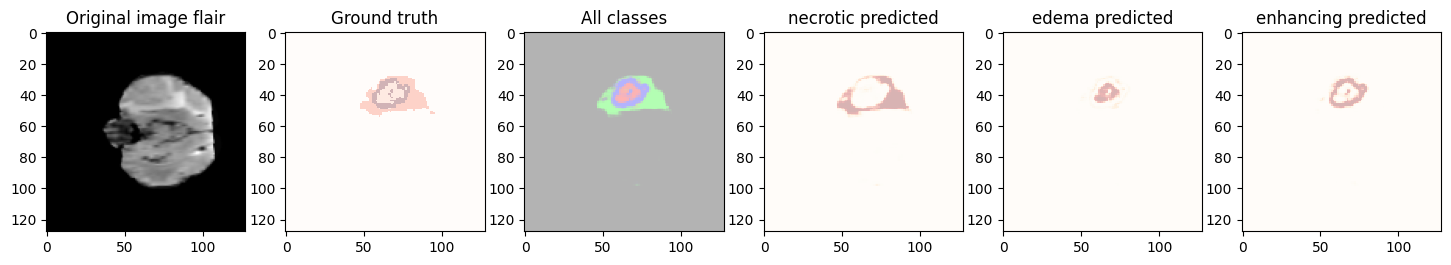

5/5 [==============================] - 4s 871ms/step


<Figure size 1800x5000 with 0 Axes>

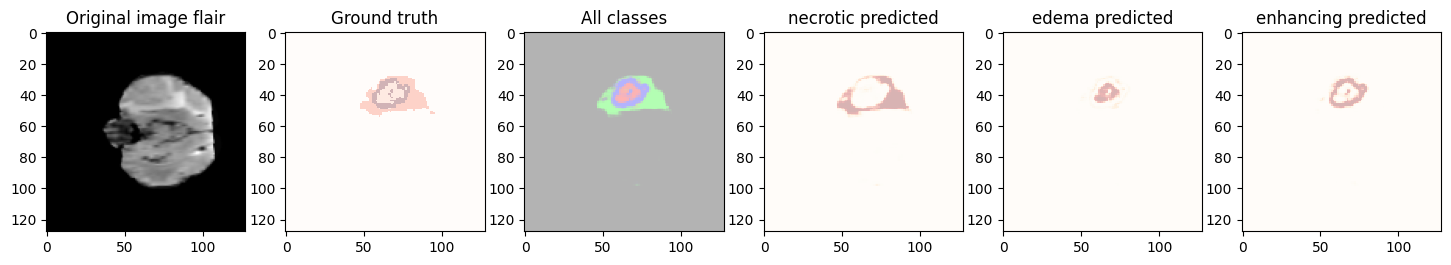

In [7]:
import tensorflow as tf
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import os

# Define the custom metrics
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_loss += loss
    total_loss /= class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, 3])) + epsilon)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Load the model with the custom metrics
model = tf.keras.models.load_model('model_2019_350.h5',
                                   custom_objects={
                                       'dice_coef': dice_coef,
                                       'dice_coef_necrotic': dice_coef_necrotic,
                                       'dice_coef_edema': dice_coef_edema,
                                       'dice_coef_enhancing': dice_coef_enhancing,
                                       'precision': precision,
                                       'sensitivity': sensitivity,
                                       'specificity': specificity,
                                       'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)
                                   }, compile=False)

def predictByPath(case_path, case):
    VOLUME_SLICES = 155  # You need to adjust this based on your data
    IMG_SIZE = 128  # Assuming your model expects 128x128 input images
    VOLUME_START_AT = 0  # Start slice index

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path_flair = os.path.join(case_path, f'{case}_flair.nii')
    vol_path_t1ce = os.path.join(case_path, f'{case}_t1ce.nii')

    flair = nib.load(vol_path_flair).get_fdata()
    ce = nib.load(vol_path_t1ce).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)
# Define visualization function
# Define prediction function
def predictByPath(case_path, case):
    VOLUME_SLICES = 155  # You need to adjust this based on your data
    IMG_SIZE = 128  # Assuming your model expects 128x128 input images
    VOLUME_START_AT = 0  # Start slice index

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path_flair = os.path.join(case_path, f'{case}_flair.nii')
    vol_path_t1ce = os.path.join(case_path, f'{case}_t1ce.nii')

    flair = nib.load(vol_path_flair).get_fdata()
    ce = nib.load(vol_path_t1ce).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)

# Define visualization function
def showPredictsById(case, start_slice=60):
    IMG_SIZE = 128
    SEGMENT_CLASSES = ['background', 'necrotic', 'edema', 'enhancing']
    path = f"./data/MICCAI_BraTS_2019_Data_Training/HGG"
    gt = nib.load(os.path.join(path, f'{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # for i in range(6):  # for each image, add brain background
    #     axarr[i].imshow(cv2.resize(origImage[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()

# Example usage
case = "BraTS19_2013_3_1"  # Replace with an actual case ID from your dataset
showPredictsById(case)

# Example usage
case = "BraTS19_2013_3_1"  # Replace with an actual case ID from your dataset
showPredictsById(case)


In [ ]:
def predict(imagePath):
    # Load the image
    img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = np.array(img).reshape(-1, 128, 128, 1)
    img = img / 255.0

    # Make the prediction
    prediction = model.predict(img)
    return prediction

prediction = predict('BraTS19_2013_3_1_flair.nii')

error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [45]:
%pip install transformers



Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 KB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 KB 2.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [46]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# GPT-Neo modelini yüklemek ve kullanmak
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-2.7B")

inputs = tokenizer("MRI nedir ve nasıl çalışır?", return_tensors="pt")
outputs = model.generate(inputs.input_ids, max_length=150)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

In [ ]:
# import os
# import numpy as np
# import cv2
# import nibabel as nib
# import matplotlib.pyplot as plt

# # Assuming VOLUME_SLICES, IMG_SIZE, VOLUME_START_AT, model, SEGMENT_CLASSES, and test_ids are already defined

# def predictByPath(case_path, case):
#     files = next(os.walk(case_path))[2]
#     X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

#     vol_path = os.path.join(case_path, f'{case}_flair.nii')
#     flair = nib.load(vol_path).get_fdata()

#     vol_path = os.path.join(case_path, f'{case}_t1ce.nii')
#     ce = nib.load(vol_path).get_fdata()

#     for j in range(VOLUME_SLICES):
#         X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
#         X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

#     predictions = model.predict(X / np.max(X), verbose=1)
#     print(f"Predictions for case {case}: {predictions}")
#     return predictions

# def showPredictsById(case, start_slice=60):
#     path = f"/kaggle/datasets/MICCAI_BraTS_2019_Data_Training/HGG/{case}/"
#     gt = nib.load(os.path.join(path, f'{case}_seg.nii')).get_fdata()
#     origImage = nib.load(os.path.join(path, f'{case}_flair.nii')).get_fdata()
#     p = predictByPath(path, case)

#     core = p[:, :, :, 1]
#     edema = p[:, :, :, 2]
#     enhancing = p[:, :, :, 3]

#     plt.figure(figsize=(18, 50))
#     f, axarr = plt.subplots(1, 6, figsize=(18, 50))

#     for i in range(6):  # for each image, add brain background
#         axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

#     axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
#     axarr[0].title.set_text('Original image flair')
#     curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
#     axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
#     axarr[1].title.set_text('Ground truth')
#     axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
#     axarr[2].title.set_text('all classes')
#     axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
#     axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
#     axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
#     axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
#     axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
#     axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
#     plt.savefig('Test_01.png')
#     plt.show()

# # Assuming test_ids is already defined and contains the test case IDs
# showPredictsById(case=test_ids[0])
# showPredictsById(case=test_ids[1][-3:])
# # showPredictsById(case=test_ids[2][-3:])
# # showPredictsById(case=test_ids[3][-3:])
# # showPredictsById(case=test_ids[4][-3:])
# # showPredictsById(case=test_ids[5][-3:])
# # showPredictsById(case=test_ids[6][-3:])


5/5 [==============================] - 4s 734ms/step


<Figure size 1800x5000 with 0 Axes>

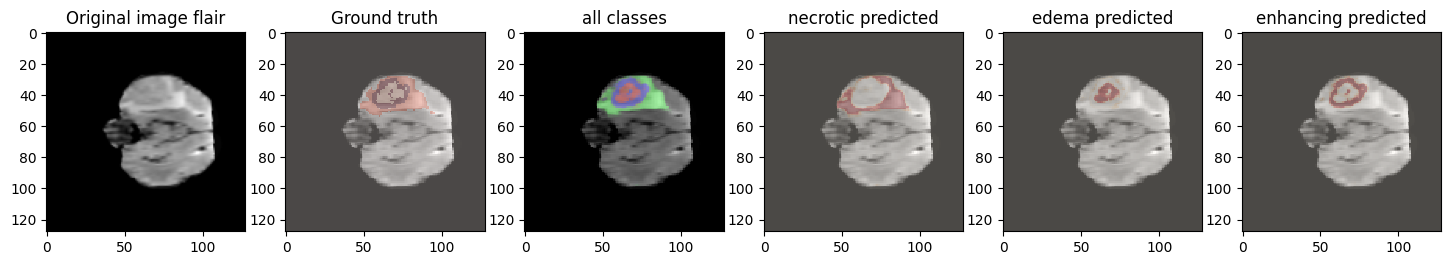

In [18]:
import tensorflow as tf
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import os
import zipfile
import io

# Define the custom metrics
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        total_loss += loss
    total_loss /= class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, 3])) + epsilon)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Load the model with the custom metrics
model = tf.keras.models.load_model('model_2019_350.h5',
                                   custom_objects={
                                       'dice_coef': dice_coef,
                                       'dice_coef_necrotic': dice_coef_necrotic,
                                       'dice_coef_edema': dice_coef_edema,
                                       'dice_coef_enhancing': dice_coef_enhancing,
                                       'precision': precision,
                                       'sensitivity': sensitivity,
                                       'specificity': specificity,
                                       'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)
                                   }, compile=False)

def predictByPath(case_path,case):
    VOLUME_SLICES = 155  # You need to adjust this based on your data
    IMG_SIZE = 128  # Assuming your model expects 128x128 input images
    VOLUME_START_AT = 0  # Start slice index

    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

    vol_path = os.path.join(case_path, f'{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)

def predictFromUploadedZip(zip_file):
    VOLUME_SLICES = 155  # You need to adjust this based on your data
    IMG_SIZE = 128  # Assuming your model expects 128x128 input images
    VOLUME_START_AT = 0  # Start slice index

    # Read the uploaded zip file
    with zipfile.ZipFile(zip_file, 'r') as z:
        # Extract all contents to a temporary directory
        z.extractall('temp_extracted')

    # Assuming files are extracted to 'temp_extracted' directory
    case_path = 'temp_extracted'

    files = os.listdir(case_path)
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'flair.nii')
    flair = nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f't1ce.nii')
    ce = nib.load(vol_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Make predictions
    predictions = model.predict(X / np.max(X), verbose=1)

    # Optionally, you can clean up the extracted files
    # os.remove(zip_file)
    # shutil.rmtree('temp_extracted')



def showPredictsById(case, start_slice = 60):
    IMG_SIZE = 128
    SEGMENT_CLASSES = ['background', 'necrotic', 'edema', 'enhancing']
    path = f"./data/MICCAI_BraTS_2019_Data_Training/HGG/{case}"
    gt = nib.load(os.path.join(path, f'{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()


showPredictsById(case='BraTS19_2013_3_1')

FileUpload(value=(), description='Upload')

5/5 [==============================] - 4s 719ms/step


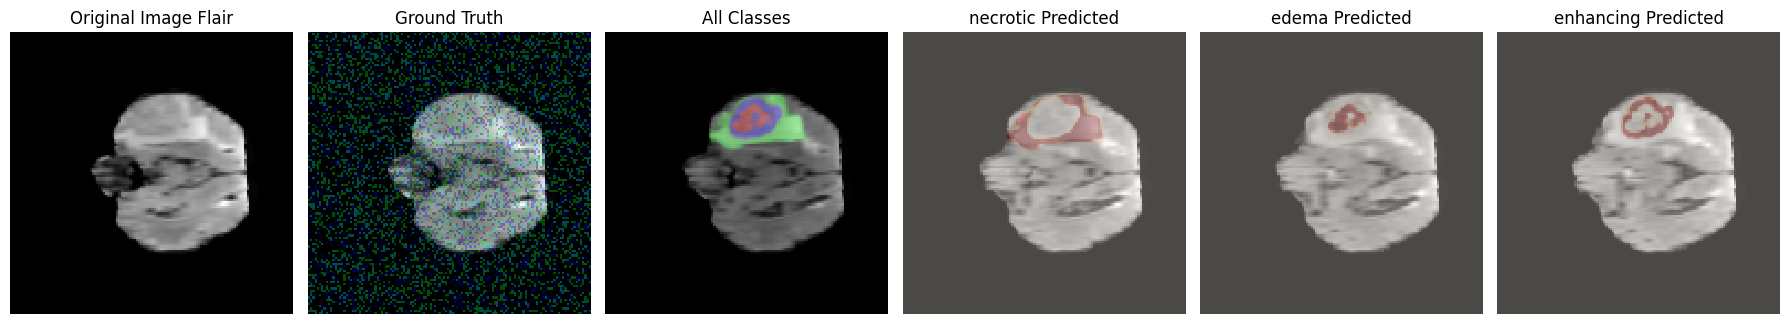

In [34]:
import tensorflow as tf
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import zipfile
from ipywidgets import FileUpload

# Load the model with the custom metrics
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = tf.keras.backend.flatten(y_true[:, :, :, i])
        y_pred_f = tf.keras.backend.flatten(y_pred[:, :, :, i])
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        loss = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
        total_loss += loss
    total_loss /= class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[:, :, :, 1])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[:, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[:, :, :, 2])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[:, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (tf.keras.backend.sum(tf.keras.backend.square(y_true[:, :, :, 3])) + tf.keras.backend.sum(tf.keras.backend.square(y_pred[:, :, :, 3])) + epsilon)

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

model = tf.keras.models.load_model('model_2019_100.h5',
                                   custom_objects={
                                       'dice_coef': dice_coef,
                                       'dice_coef_necrotic': dice_coef_necrotic,
                                       'dice_coef_edema': dice_coef_edema,
                                       'dice_coef_enhancing': dice_coef_enhancing,
                                       'precision': precision,
                                       'sensitivity': sensitivity,
                                       'specificity': specificity,
                                       'accuracy': tf.keras.metrics.MeanIoU(num_classes=4)
                                   }, compile=False)

def predictFromUploadedZip(zip_file, zip_name):
    VOLUME_SLICES = 155  # Adjust based on your data
    IMG_SIZE = 128  # Assuming your model expects 128x128 input images
    VOLUME_START_AT = 0  # Start slice index

    # Read the uploaded zip file
    with zipfile.ZipFile(zip_file, 'r') as z:
        # Extract all contents to a temporary directory
        z.extractall('temp_extracted')
    
    # Assuming files are extracted to 'temp_extracted' directory
    case_path = f'./temp_extracted/{zip_name}'

    # List files in the extracted directory
    files = os.listdir(case_path)

    # Load and prepare the data
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Load flair.nii
    vol_path_flair = os.path.join(case_path, f'{zip_name}_flair.nii')
    flair = nib.load(vol_path_flair).get_fdata()

    # Load t1ce.nii
    vol_path_t1ce = os.path.join(case_path, f'{zip_name}_t1ce.nii')
    ce = nib.load(vol_path_t1ce).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Make predictions
    predictions = model.predict(X / np.max(X), verbose=1)

    # Optionally, you can clean up the extracted files
    # os.remove(zip_file)
    # shutil.rmtree('temp_extracted')

    return predictions

def showPredictsByUploadedZip(zip_file, zip_name, case='uploaded_case', start_slice=60):
    IMG_SIZE = 128
    SEGMENT_CLASSES = ['background', 'necrotic', 'edema', 'enhancing']

    # Predict using uploaded zip file
    predictions = predictFromUploadedZip(zip_file, zip_name)

    core = predictions[:,:,:,1]
    edema = predictions[:,:,:,2]
    enhancing = predictions[:,:,:,3]

    # Load and prepare the data for visualization
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall('temp_extracted')
    
    case_path = f'./temp_extracted/{zip_name}'

    # Load flair.nii for original image visualization
    vol_path_flair = os.path.join(case_path, f'{zip_name}_flair.nii')
    flair = nib.load(vol_path_flair).get_fdata()

    # Load ground truth if available (replace with actual ground truth loading code)
    # Example: loading ground truth for demonstration purposes
    gt = np.zeros_like(predictions)
    gt[:, :, :, 1] = np.random.randint(0, 2, size=gt[:, :, :, 1].shape)  # Necrotic
    gt[:, :, :, 2] = np.random.randint(0, 2, size=gt[:, :, :, 2].shape)  # Edema
    gt[:, :, :, 3] = np.random.randint(0, 2, size=gt[:, :, :, 3].shape)  # Enhancing

    fig, axarr = plt.subplots(1, 6, figsize=(18, 8))

    for i in range(6):
        slice_index = start_slice + i
        if slice_index < flair.shape[2]:
            axarr[i].imshow(cv2.resize(flair[:,:,slice_index], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
            axarr[i].axis('off')

    axarr[0].set_title('Original Image Flair')

    if 'gt' in locals():
        curr_gt = cv2.resize(gt[:,:,start_slice], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
        axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
        axarr[1].set_title('Ground Truth')

    axarr[2].imshow(predictions[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].set_title('All Classes')

    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].set_title(f'{SEGMENT_CLASSES[1]} Predicted')

    axarr[4].imshow(core[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].set_title(f'{SEGMENT_CLASSES[2]} Predicted')

    axarr[5].imshow(enhancing[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].set_title(f'{SEGMENT_CLASSES[3]} Predicted')

    plt.tight_layout()
    plt.savefig('Test_01.png')
    plt.show()

# Function to handle file upload and trigger prediction
def on_file_upload(change):
    uploaded_file = change['new'][0]
    if 'content' in uploaded_file:
        zip_name = uploaded_file['name'].split('.')[0]  # Extract the file name without extension
        with open('uploaded.zip', 'wb') as f:
            f.write(uploaded_file['content'])
        showPredictsByUploadedZip('uploaded.zip', zip_name)

# Display file upload widget
file_upload = FileUpload()
file_upload.observe(on_file_upload, names=['value'])
display(file_upload)
